<a href="https://colab.research.google.com/github/AlexeyEvzrezov/DS_projects/blob/master/ore_recovery_efficiency_prediction/ore_recovery_efficiency_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание коэффициента восстановления золота из золотосодержащей руды

<a id="0"></a> 
## Описание данных и технологический процесс
Данные находятся в трёх файлах:
- `gold_recovery_train.csv` — обучающая выборка;
- `gold_recovery_test.csv` — тестовая выборка;
- `gold_recovery_full.csv` — исходные данные.

Данные индексируются датой и временем получения информации (признак `date`).  Соседние по времени параметры часто похожи.  
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.  
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.  
В нашем распоряжении сырые данные: их просто выгрузили из хранилища.  

### Технологический процесс  
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.
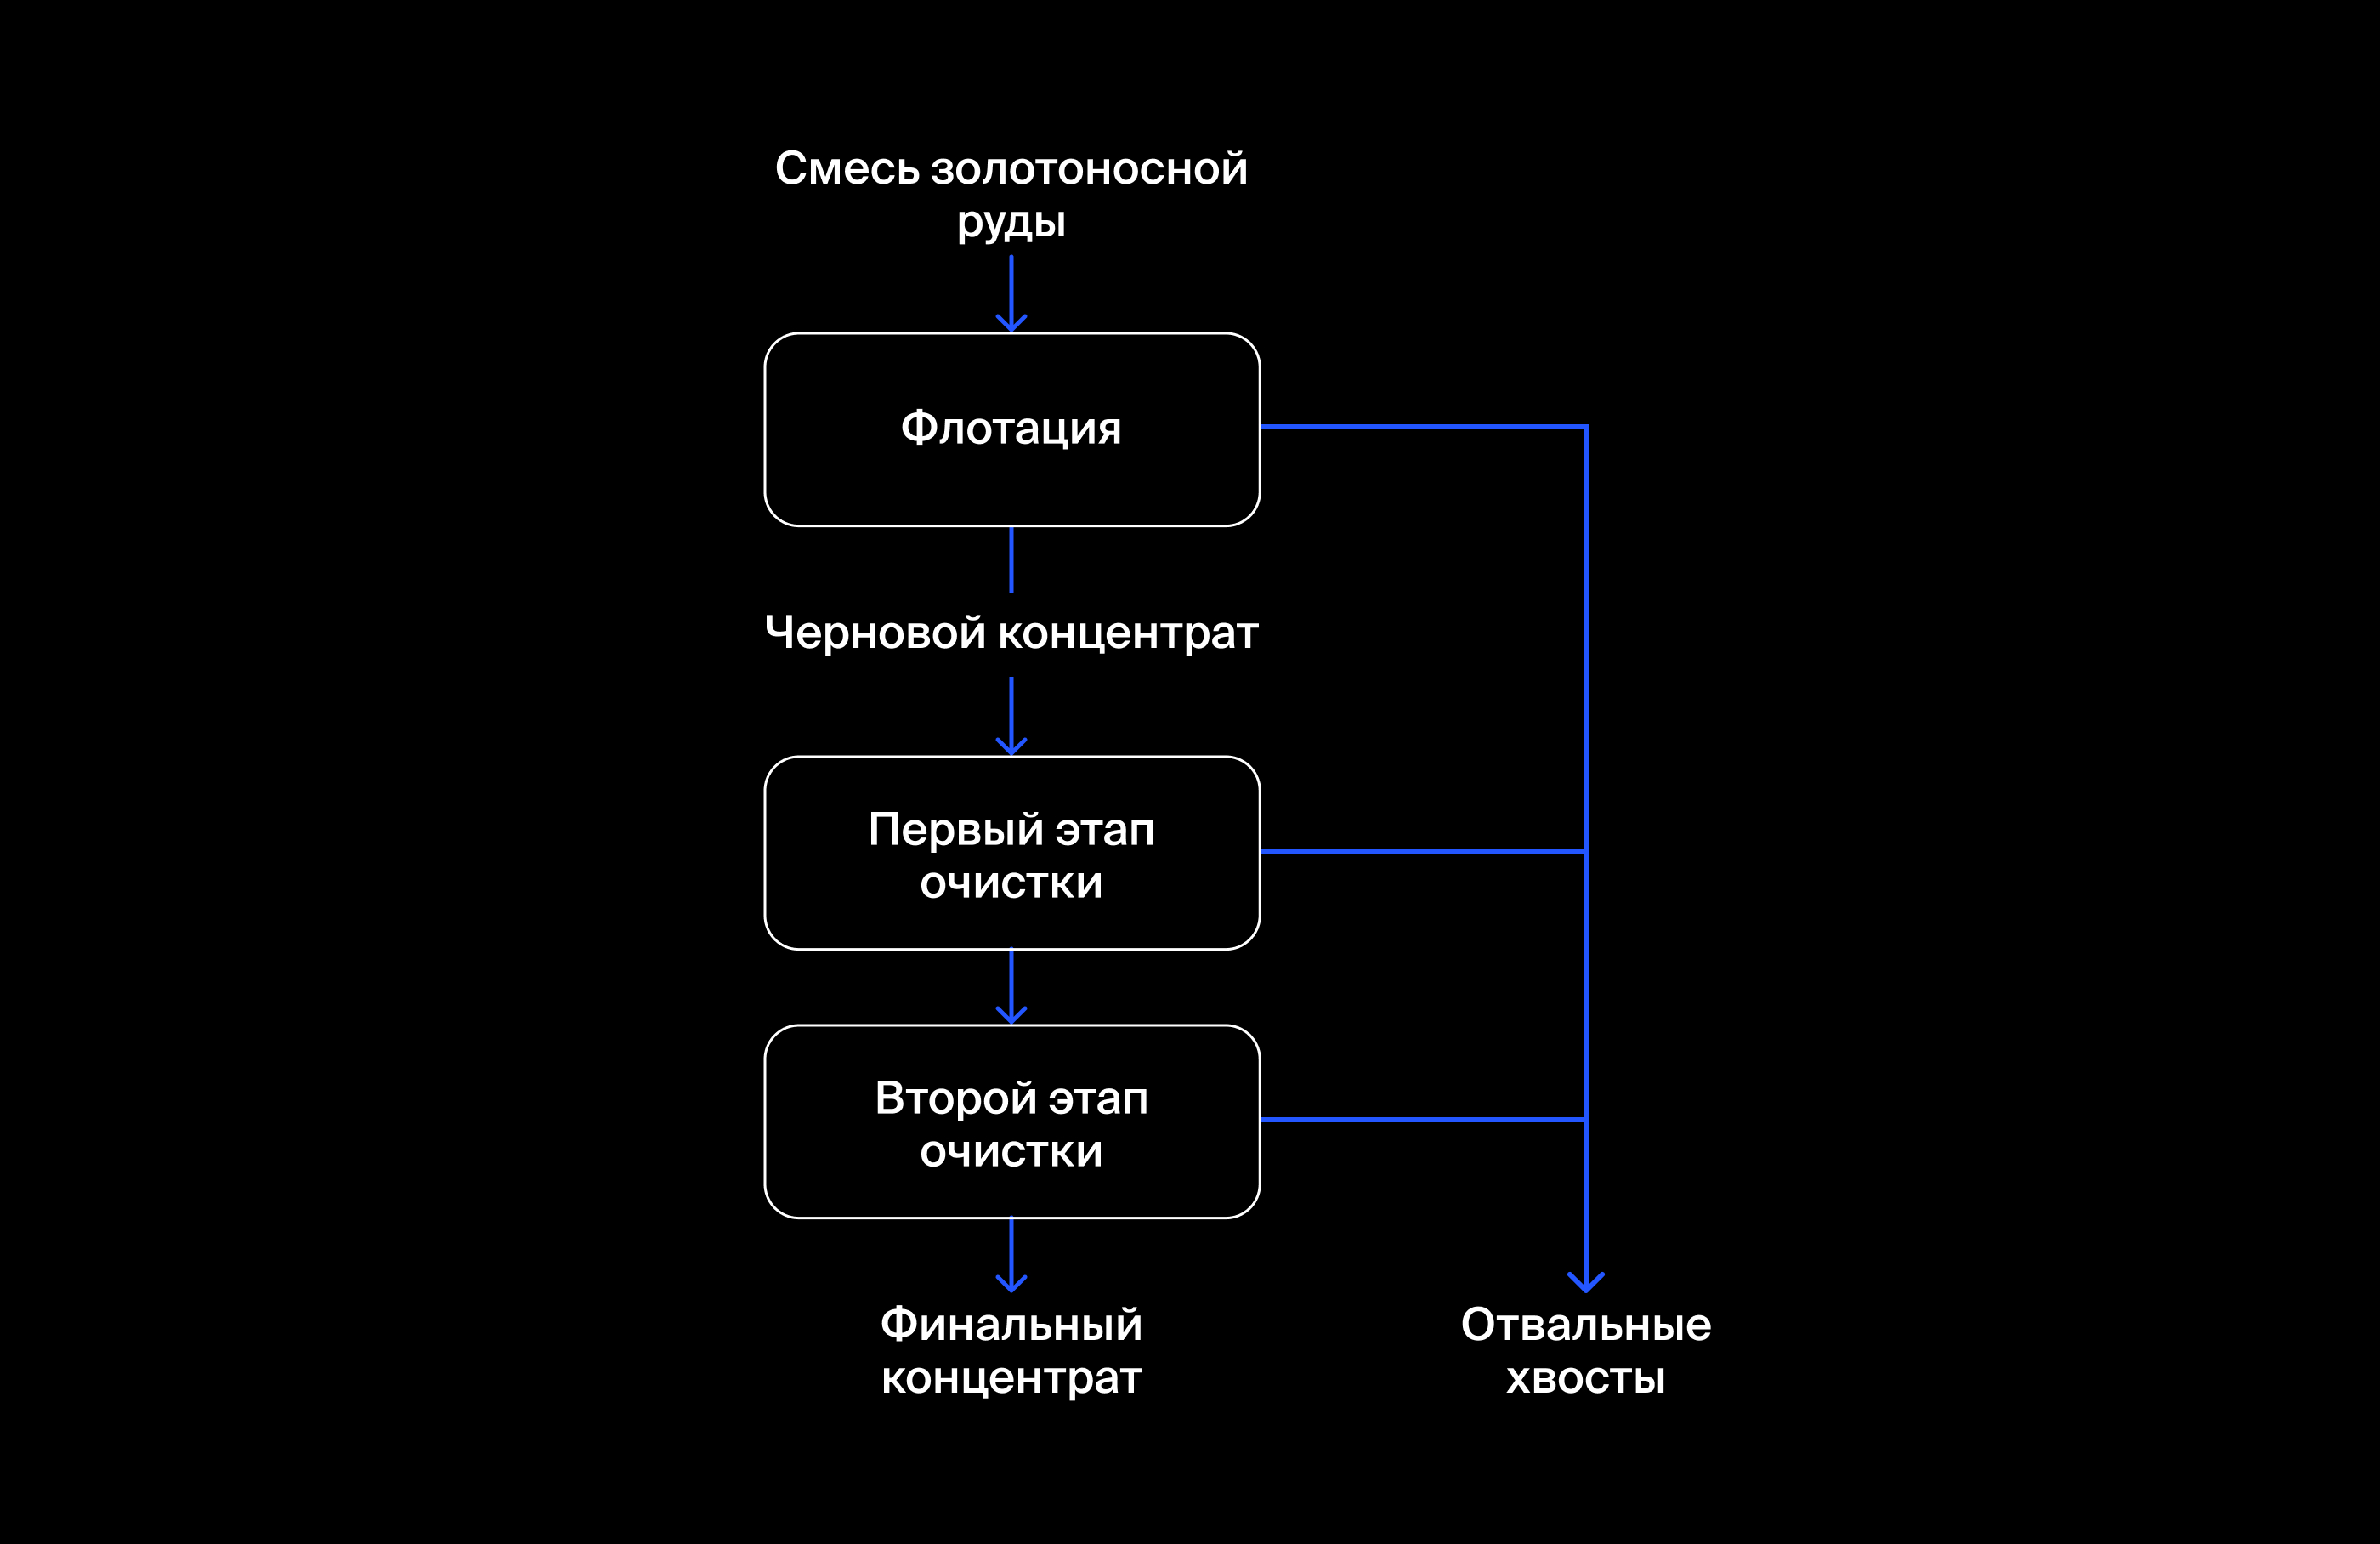

Опишем каждую стадию:
1. Флотация  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.  
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка  
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.  

## Описание данных
**Технологический процесс**
- *Rougher feed* — исходное сырье
- *Rougher additions* (или *reagent additions*) — флотационные реагенты: Xanthate, Sulphate, Depressant
  - *Xanthate* **— ксантогенат (промотер, или активатор флотации);
  - *Sulphate* — сульфат (на данном производстве сульфид натрия);
  - *Depressant* — депрессант (силикат натрия).

- *Rougher process* (англ. «грубый процесс») — флотация
- *Rougher tails* — отвальные хвосты
- *Float banks* — флотационная установка
- *Cleaner process* — очистка
- *Rougher Au* — черновой концентрат золота
- *Final Au* — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

### Наименование признаков
Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`
Пример: `rougher.input.feed_ag`
Возможные значения для блока `[этап]`:
- *rougher* — флотация
- *primary_cleaner* — первичная очистка
- *secondary_cleaner* — вторичная очистка
- *final* — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- *input* — параметры сырья
- *output* — параметры продукта
- *state* — параметры, характеризующие текущее состояние этапа
- *calculation* — расчётные характеристики

### Расчёт эффективности
Нам нужно смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле
$$\text{Recovery} = {C(F-T)\over{F(C-T)}}\times100\%,$$
где:  
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах.  Причём важен не только финальный продукт, но и черновой концентрат.  

### Метрика качества
Для решения задачи введём новую метрику качества — **sMAPE** (англ. *Symmetric Mean Absolute Percentage Error* «симметричное среднее абсолютное процентное отклонение»).  

Она похожа на *MAE*, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.  
Метрика sMAPE вычисляется так:
$$sMAPE={1\over{N}}\sum\limits_{i=1}^N{{|y_i-\hat{y_i}|}\over{(|y_i|+|\hat{y_i}|)/2}}\times100\%,$$  
где:
- $y_i$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество;
- $\hat{y_i}$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке;
- $N$ - количество объектов в выборке.  

Необходимо спрогнозировать сразу две величины:
1. эффективность обогащения чернового концентрата `rougher.output.recovery`;
2. эффективность обогащения финального концентрата `final.output.recovery`.  

Итоговая метрика складывается из двух величин:
$$\text{Итоговое sMAPE} = 25\%\times\text{sMAPE(rougher)}+75\%\times\text{sMAPE(final)}$$





<a id="1"></a> 
## Загрузка и подготовка данных

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import Image

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel

import scipy.stats as st

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

В настоящей работе представлен прототип модели машинного обучения для компании «Цифра». Компания разрабатывает решения для эффективной работы промышленных предприятий.  

Модель предсказывает коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.  

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Содержание
- [Описание данных и технологический процесс](#0)
1. [Загрузка и подготовка данных](#1)    
2. [Исследовательский анализ данных](#2)    
3. [Построение моделей](#3)
- [Выводы](#6)

Загрузим данные и переведем даты в соответствующий формат, сделав их индексами.

In [3]:
names = ['train', 'test', 'full']
train, test, full = [pd.read_csv(f'/content/drive/My Drive/Datasets/gold_recovery_{name}.csv',
                   parse_dates=True, index_col='date') for name in names]
dfs = [train, test, full]                   

Проверим типы данных, пропуски и имеющиеся признаки в каждом датафрейме.

In [4]:
info = []
for df in dfs:
    info.append(pd.DataFrame({
        'Column': df.columns, 
        'NaN '+str(df.shape): [df[col].isna().sum() for col in df.columns],     # кол-во пропусков и shape в заголовке
        'NaN ratio': [df[col].isna().sum()/len(train) for col in df.columns]    # доля пропусков
        }))
    print('Имеющиеся типы данных: ', *set(df.dtypes))                           # уникальные типы данных
    
(info[0].merge(info[1], on='Column', how='outer')                               # объединим по названиям признаков
        .merge(info[2], on='Column', how='outer'))

Имеющиеся типы данных:  float64
Имеющиеся типы данных:  float64
Имеющиеся типы данных:  float64


,Column,"NaN (16860, 86)",NaN ratio_x,"NaN (5856, 52)",NaN ratio_y,"NaN (22716, 86)",NaN ratio
0,final.output.concentrate_ag,72,0.004,nan,nan,89,0.005
1,final.output.concentrate_pb,72,0.004,nan,nan,87,0.005
2,final.output.concentrate_sol,370,0.022,nan,nan,385,0.023
3,final.output.concentrate_au,71,0.004,nan,nan,86,0.005
4,final.output.recovery,1521,0.090,nan,nan,1963,0.116
5,final.output.tail_ag,66,0.004,nan,nan,83,0.005
6,final.output.tail_pb,183,0.011,nan,nan,200,0.012
7,final.output.tail_sol,145,0.009,nan,nan,271,0.016
8,final.output.tail_au,66,0.004,nan,nan,81,0.005
9,primary_cleaner.input.sulfate,1307,0.078,302.000,0.018,1609,0.095


Типы данных в порядке. Пропусков не много. В тестовом наборе отсутствуют целевые и некоторые другие признаки, а именно выходные параметры продукта на всех стадиях и расчетные характеристики на стадии флотации.
________________________________________________

Напишем функцию для расчета эффективности обогащения.

In [5]:
def recovery(c, f, t):
    """
    Ore recovery efficiency.
    Parameters
    ----------
    c : array-like or float
        Output Au concentration
    f : array-like or float
        Feed Au concentration
    t : array-like or float
        Tail Au concentration
    Returns
    -------
    Efficiency percentage: float
        Efficiency output is non-negative floating point expressed as a percentage. 
        The best value is 100.0.
    """
    return c * (f - t) / f / (c - t) * 100

Рассчитаем эффективность обогащения на обучающей выборке для признака `rougher.output.recovery` и найдем MAE между нашими расчётами и значением признака.  
Для адекватности сравнения предварительно удалим пропуски в интересующих нас столбцах.

In [6]:
d = train[['rougher.output.concentrate_au', 
           'rougher.input.feed_au', 
           'rougher.output.tail_au',
           'rougher.output.recovery']
          ].dropna()
rec = recovery(d.iloc[:,0], d.iloc[:,1], d.iloc[:,2])
print('MAE:', mean_absolute_error(rec, d.iloc[:,3]))
display(pd.DataFrame(
    rec.describe(), columns=['calculation']).join(
        d.iloc[:,3].describe()))

MAE: 1.0512313043960013e-14


,calculation,rougher.output.recovery
count,"14,287.000","14,287.000"
mean,82.394,82.394
std,15.097,15.097
min,-0.000,0.000
25%,79.818,79.818
50%,85.236,85.236
75%,90.132,90.132
max,100.000,100.000


Очевидно, что эффективность обогащения рассчитана верно.  
Обратим внимание на наличие нулевых значений, что означает либо нулевую долю золота после флотации, либо равные доли золота в сырье и отвальных частях. Обратим на это внимание в дальнейшей работе.

На данном этапе не будем проводить обработку пропусков и подозрительных значений. Вернемся к этому после дополнительного анализа перед обучением моделей.

<a id="2"></a> 
## 2. Исследовательский анализ данных


Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [7]:
metals = ['au', 'ag', 'pb']

# выделим стадии
stages = [i[:-2] for i in full.columns if 'concentrate_au' in i or 'feed_au' in i]
stages

['final.output.concentrate_',
 'primary_cleaner.output.concentrate_',
 'rougher.input.feed_',
 'rougher.output.concentrate_']

In [8]:
# упорядочним выделенные стадии
stages = ['rougher.input.feed_',
          'rougher.output.concentrate_',
          'primary_cleaner.output.concentrate_',
          'final.output.concentrate_']

In [9]:
# зададим цвета металлов для отображения на всех графиках
def metal_color(metal):
    return 'gold' if metal=='au' else 'silver' if metal=='ag' else 'dimgrey'

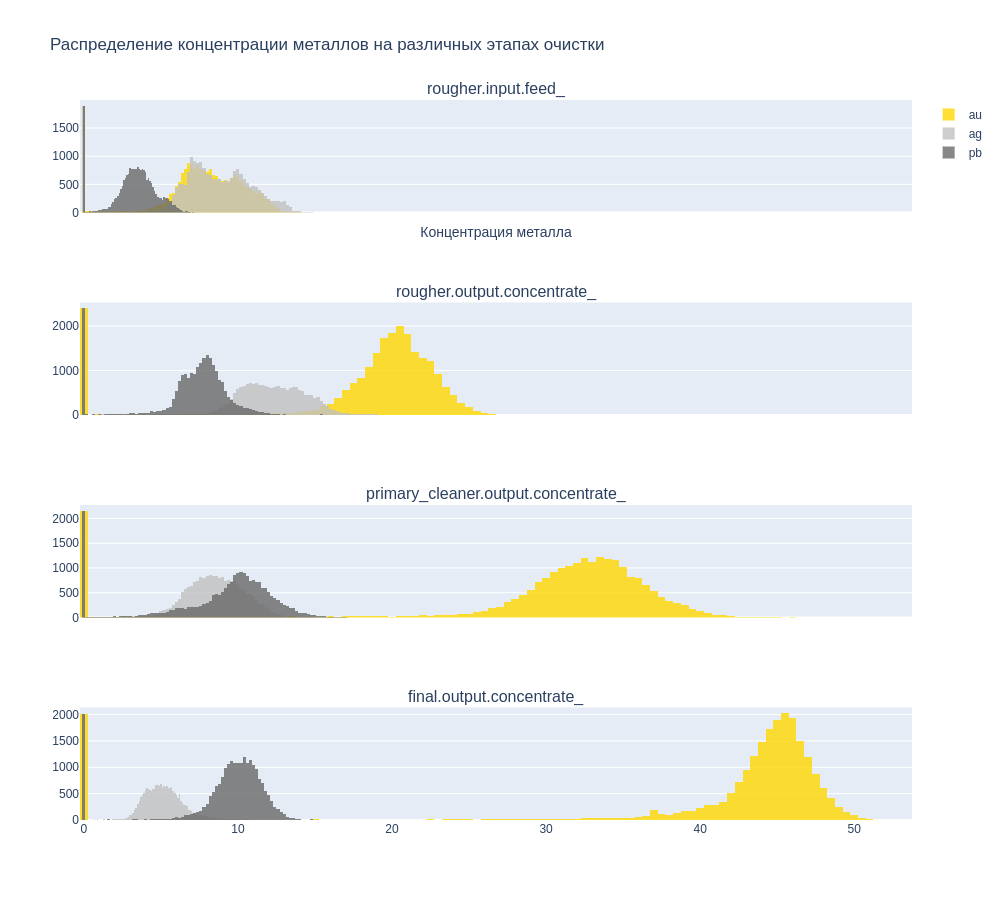

In [10]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=stages)

for stage in stages:
    for metal in metals:
        fig.add_trace(go.Histogram(x=full[stage+metal], 
                                   name=metal, 
                                   marker=dict(color=metal_color(metal)),
                                   showlegend=True if stage==stages[0] else False,
                                   opacity=0.8
                                   ), stages.index(stage)+1,1) 
fig.update_layout(title='Распределение концентрации металлов на различных этапах очистки', 
                  xaxis_title='Концентрация металла', 
                  barmode='overlay',
                  height=900, 
                  width=1000)

img = fig.to_image(format='png', width=1000, height=900)
Image(img)

Сразу же заметим большое количество нулевых значений.  
Дополнительно визуализируем изменение средней концентрации от стадии к стадии.

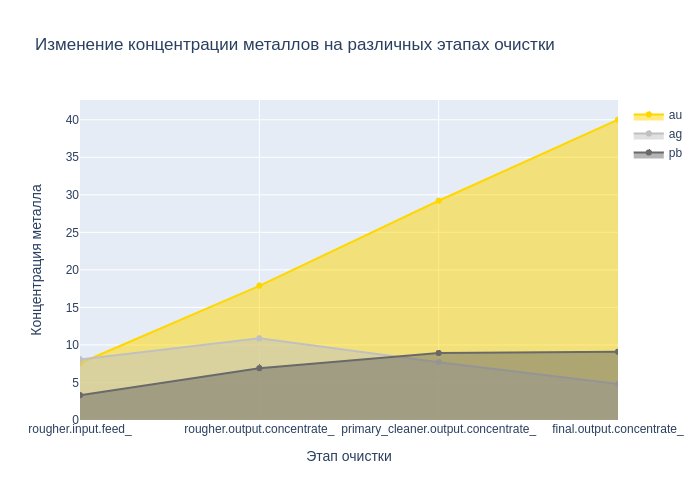

In [11]:
d = {}
fig = go.Figure()
for metal in metals:
    d[metal] = [full[stage+metal].mean() for stage in stages] 
    fig.add_trace(go.Scatter(y=d[metal], x=stages, name=metal, fill='tozeroy', 
    line_color=metal_color(metal)))
mean_concentrate = pd.DataFrame(d, index=stages)
fig.update_layout(title='Изменение концентрации металлов на различных этапах очистки', 
                  xaxis_title='Этап очистки', 
                  yaxis_title='Концентрация металла')

img = fig.to_image(format='png')
Image(img)

Видно, что от этапа к этапу средняя концентрация золота возрастает, причем линейно.
________________________________________

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

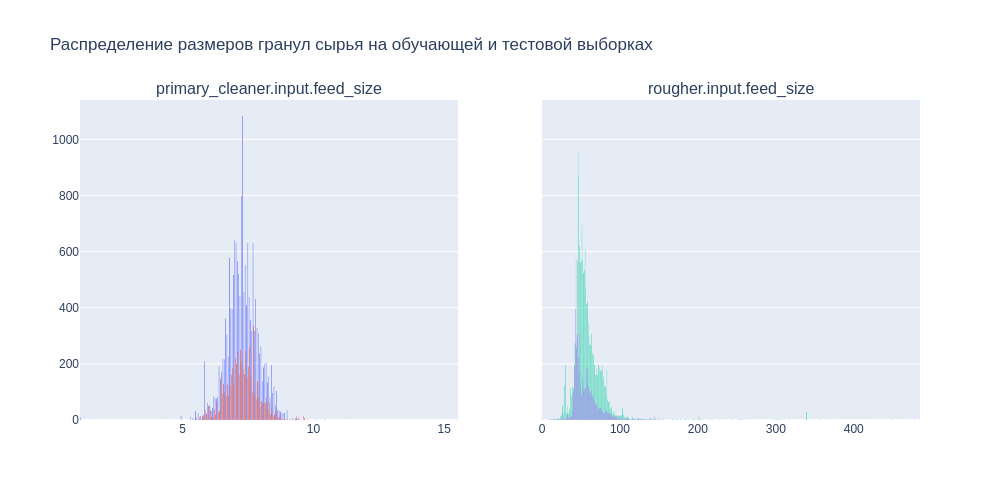

In [12]:
feed_sizes = [i for i in full.columns if 'feed_size' in i]
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, 
                    subplot_titles=feed_sizes)
describe_list = []

for feed_size in feed_sizes:
    for df in dfs[:2]:
        fig.add_trace(go.Histogram(x=df[feed_size]), 
                      1, feed_sizes.index(feed_size)+1)    
        describe_list.append(df[feed_size].describe())

fig.update_layout(title='Распределение размеров гранул сырья на обучающей и тестовой выборках',
                  showlegend=False)

img = fig.to_image(format='png', width=1000, height=500)
Image(img)

In [13]:
pd.concat(describe_list, axis=1)

,primary_cleaner.input.feed_size,primary_cleaner.input.feed_size,rougher.input.feed_size,rougher.input.feed_size
count,"16,860.000","5,856.000","16,443.000","5,834.000"
mean,7.297,7.265,58.676,55.938
std,0.619,0.612,23.923,22.724
min,1.080,5.650,9.660,0.046
25%,6.940,6.886,47.576,43.891
50%,7.285,7.259,54.104,50.002
75%,7.700,7.650,65.051,61.638
max,10.470,15.500,484.967,477.445


Очевидно, что распределения очень похожи. Среднее, среднеквадратическое отклонение и 1-3 квартили примерно равны. Мы уверенно можем использовать такие данные для будущей оценки модели.  
________________________________________________________________

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [14]:
# список всех веществ
substances = metals
substances.append('sol')

In [15]:
# просуммируем концентрации по каждой стадии
for df in train, full:
    for stage in stages:
        df[stage + 'total'] = df[[x for x in df.columns if stage in x \
                                and any(s in x for s in substances)]
                                 ].sum(axis=1)                         

In [16]:
# список значений суммарных концентраций
totals = [x for x in full.columns if 'total' in x]

Построим диаграммы размаха.

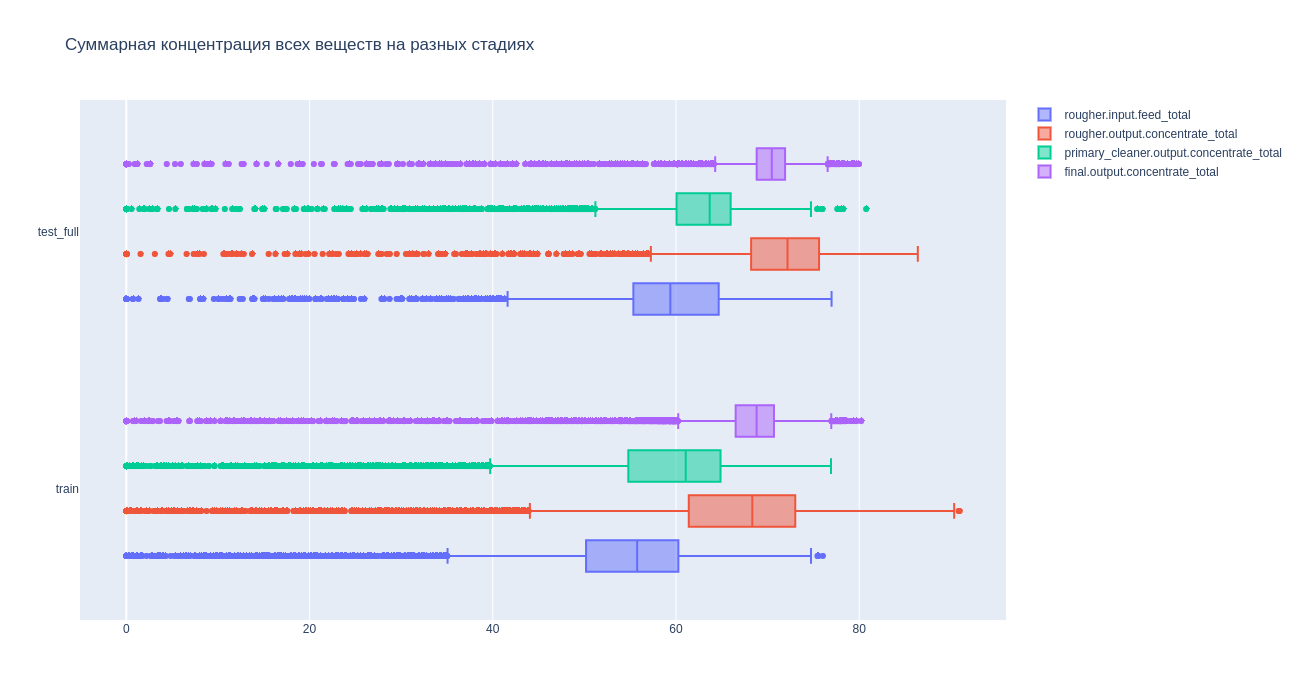

In [17]:
fig = go.Figure()
test_full = full.loc[test.index,:]                                              # выделим тестовую выборку со всеми признаками из полной
_ = pd.concat([train[totals], test_full[totals]])                               # <для группировки диаграмм
y = ['train'] * len(train) + ['test_full'] * len(test_full)                     # по выборкам> 

for col in totals:
    fig.add_trace(go.Box(x=_[col], y=y, name=col))

fig.update_traces(orientation='h')
fig.update_layout(title='Суммарная концентрация всех веществ на разных стадиях',
                  boxmode='group',
                  height=700
                  )
img = fig.to_image(format='png', width=1300, height=700)
Image(img)

Можно наблюдать большое количество выбросов снизу вплоть до нулевых значений (которых довольно много, что мы уже видели при анализе распределения концентраций металлов).  
Обратим внимание, что статистики на тестовой выборке в целом имеют несколько более высокие значения по сравнению с обучающей выборкой.


Посмотрим на количество нулевых значений.

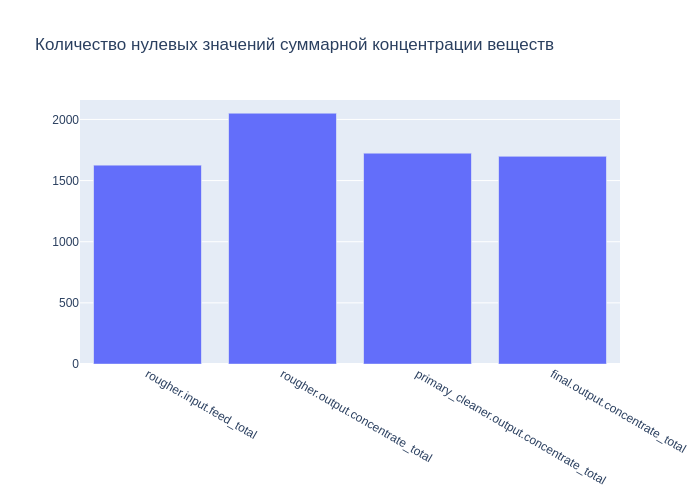

In [18]:
fig = go.Figure(data=go.Bar(
    x=totals,
    y=[len(full[full[x]==0]) for x in totals]
))
fig.update_layout(title='Количество нулевых значений суммарной концентрации веществ')

img = fig.to_image(format='png')
Image(img)

Нулевых значений довольно много. Лучше отбросить их при построении моделей.

Посмотрим на корреляцию признаков.

In [19]:
# удалим ранее созданные вспомогательные столбцы
train = train.drop(totals, axis=1)
full = full.drop(totals, axis=1)

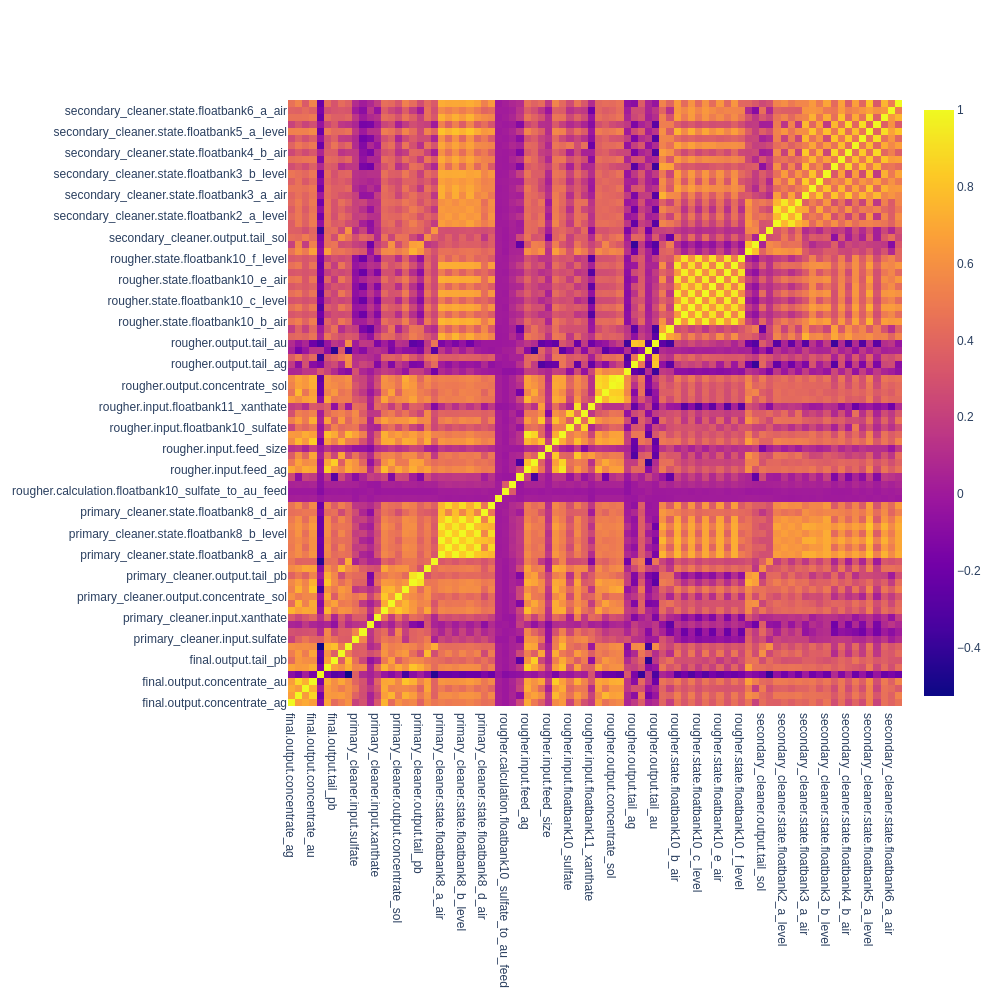

In [20]:
corr = train.corr()
fig = go.Figure(data=go.Heatmap(z=corr, x=corr.index, y=corr.columns))

img = fig.to_image(format='png', width=1000, height=1000)
Image(img)

Мы видим сильную взаимную корреляцию значений параметров флотационных установок.

Обратим внимание на наличие связи между признаками, отсутствующими в тестовой выборке и признаками, значения которых доступны для обучения.  
Здесь можно выделить следующее:
- `rougher.input.feed_ag` и `final.output.tail_ag`: 0.85
- `rougher.input.feed_pb` и `final.output.tail_pb`: 0.84
- `rougher.input.feed_sol` и `final.output.concentrate_au`: 0.83

Наибольший интерес в данном случае вызывает последняя связка.

<a id="3"></a> 
## 3. Построение моделей

Напишем функции для расчета метрик sMAPE, которые будем использовать для оценки качества моделей, а также функцию для расчета процентного уменьшения одного значения относительно доугого. 

In [21]:
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error (sMAPE).
    Parameters
    ----------
    y_true : array-like
        Correct target values.
    y_pred : array-like or float
        Estimated target values.
    Returns
    -------
    error : float
        sMAPE output is non-negative floating point expressed as a percentage. 
        The best value is 0.0.
    """
    y_dev_abs = abs(y_true - y_pred)
    y_abs_mean = (abs(y_true) + abs(y_pred)) / 2
    output_errors = sum(y_dev_abs / y_abs_mean) / len(y_true)
    return output_errors * 100


def smape_agg(smape_rougher, smape_final):
    """
    Calculates aggregated sMAPE.
    """
    return 0.25 * smape_rougher + 0.75 * smape_final


def error_decrease(smape_total, smape_total_const):
    """
    Calculates absolute percentage decrease
    """  
    return abs(smape_total / smape_total_const - 1) * 100

Подготовим данные для обучения моделей.  
Исходя из проведенного анализа данных примем следующие решения:
- Параметры флотационных установок использовать не будем;
- Пропуски удалим;
- Удалим выбросы.


In [22]:
full_cleaned = full[[x for x in full.columns \
                     if 'floatbank' not in x ]].dropna()                        # уберем параметры установок и пропуски

full_cleaned = full_cleaned[(np.abs(st.zscore(full_cleaned)) < 3).all(axis=1)]  # уберем выбросы

test_cleaned = full_cleaned.loc[[x for x in test.index \
                                 if x in full_cleaned.index], :]                # восстановим test со всеми признаками по индексам из него

train_cleaned = full_cleaned.loc[[x for x in train.index \
                                  if x in full_cleaned.index], :]               # восстановим train по индексам из него

Начнем с предсказания значений `rougher.output.recovery`.  
Для этой задачи оставим только признаки, относящиеся к соответствующему этапу. Также не забудем исключить признаки, рассчитываемые позже.

In [23]:
rougher_features = [x for x in train_cleaned.columns \
                    if 'rougher' in x and x in test.columns]

X_train_rougher = train_cleaned[rougher_features]
y_train_rougher = train_cleaned['rougher.output.recovery']
X_test_rougher = test_cleaned[rougher_features]
y_true_rougher = test_cleaned['rougher.output.recovery']

Перейдем к `final.output.recovery`.  
Подготовим выборки.

In [24]:
final_features = [x for x in train_cleaned.columns if x in test.columns]
X_train_final = train_cleaned[final_features]
y_train_final = train_cleaned['final.output.recovery']
X_test_final = test_cleaned[final_features]
y_true_final = test_cleaned['final.output.recovery']

Рассмотрим разные модели и оценим качество на кросс-валидации.  

Создадим оценщик для использования sMAPE в качестве метрики качества.

In [25]:
scorer = make_scorer(smape, greater_is_better=False)

Создадим сетку из различных моделей и их гиперпараметров. 

In [26]:
pipe = Pipeline([('regression', LinearRegression())])
param_grid = [
              {'regression': [LinearRegression()]},
              {'regression': [LassoCV(normalize=True, random_state=0)]},
              {'regression': [GradientBoostingRegressor(random_state=0)],
               'regression__n_estimators': [150, 300],
               },     
             ]

grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring=scorer, cv=5)

Сделаем функции для вывода на экран информации, получаемой по результатам выбора моделей и оценки качества на кросс-валидации.

In [27]:
def print_GridSearchCV(grid):
    print('Результаты кросс-валидации на обучающей выборке')
    print('-----------------------------------------------')
    print('sMAPE: %0.3f %%'%abs(grid.best_score_))
    print()
    print('Лучшая модель:')
    print(grid.best_params_)
    print('-----------------------------------------------')


def print_smape(smape):
    print('Значение sMAPE на тестовой выборке:\n%0.3f %%' %smape)

Перейдем непосредственно к обучению и оценке качества.  
Сначала рассмотрим `rougher.output.recovery`.

In [28]:
rougher_grid = grid_search.fit(X_train_rougher, y_train_rougher)
y_pred_rougher = rougher_grid.predict(X_test_rougher)
smape_rougher = smape(y_true_rougher, y_pred_rougher)

Посмотрим на результаты.

In [29]:
print_GridSearchCV(rougher_grid)
print_smape(smape_rougher)

Результаты кросс-валидации на обучающей выборке
-----------------------------------------------
sMAPE: 5.627 %

Лучшая модель:
{'regression': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), 'regression__n_estimators': 150}
-----------------------------------------------
Значение sMAPE на тестовой выборке:
3.746 %


Перейдем к `final.output.recovery`.

In [30]:
final_grid = grid_search.fit(X_train_final, y_train_final)
y_pred_final = final_grid.predict(X_test_final)
smape_final = smape(y_true_final, y_pred_final)

In [31]:
print_GridSearchCV(final_grid)
print_smape(smape_final)

Результаты кросс-валидации на обучающей выборке
-----------------------------------------------
sMAPE: 7.119 %

Лучшая модель:
{'regression': LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=0, selection='cyclic',
        tol=0.0001, verbose=False)}
-----------------------------------------------
Значение sMAPE на тестовой выборке:
6.046 %


Рассчитаем итоговое sMAPE.

In [32]:
smape_total = smape_agg(smape_rougher, smape_final)
print('Итогоговое sMAPE: %0.3f %%'%smape_total)

Итогоговое sMAPE: 5.471 %


Рассмотрим константную модель и сравним результаты. Для сопоставимости оценок будем использовать медианные значения целевых переменных из обучающей выборки.

In [33]:
smape_rougher_const = smape(y_true_rougher, y_train_rougher.median())
smape_final_const = smape(y_true_final, y_train_final.median())
smape_total_const = smape_agg(smape_rougher_const, smape_final_const)
print('Итогоговое sMAPE для константной модели: %0.3f %%'%smape_total_const)

Итогоговое sMAPE для константной модели: 6.221 %


Рассчитаем, какое уменьшение ошибки позволяют получить построенные модели по сравнению с константной моделью.

In [34]:
print('Итоговое значение sMAPE на %0.2f %% меньше по сравнению с константной моделю'\
      %error_decrease(smape_total, smape_total_const))

Итоговое значение sMAPE на 12.07 % меньше по сравнению с константной моделю


Таким образом, наши модели выполняют свою задачу, хотя качество предсказаний не намного выше, чем у константной модели.  

Отметим, что более тщательная работа с гиперпараметрами и перебор различных значений по сетке позволяют добиться некоторого улучшения результатов, но совсем незначительного, и мы не приводим здесь соответствующие выкладки, требующие длительного времени выполнения кода.  
________________________________________


Попробуем теперь реализовать иной подход. 
- Удалим пропуски только в значениях целевых переменных, сохраним все исходные признаки;
- Удалим нулевые значения;
- Восстановим оставшиеся пропуски методом k ближайших соседей;
- Предусмотрим возможность отбора признаков с использованием `SelectFromModel` и оценим модели на кросс-валидации.

Сформируем новые выборки для реализации вышеописанного подхода.

In [35]:
full_ = full.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])# удалим объекты, имеющие пропуски в целевых переменных
full_ = full_[(full_ != 0).all(axis=1)]  
test_ = full_.loc[[x for x in test.index if x in full_.index], :]               # восстановим test по индексам из него
train_ = full_.loc[[x for x in train.index if x in full_.index], :]             # восстановим train по индексам из него

X_train_ = train_[[x for x in train_.columns if x in test.columns]]             # все признаки, имеющиеся в оригинальной тестовой выборке
y_train_rougher_ = train_['rougher.output.recovery']
y_train_final_ = train_['final.output.recovery']
X_test_ = test_[[x for x in test_.columns if x in test.columns]]                # все признаки, имеющиеся в оригинальной тестовой выборке
y_true_rougher_ = test_['rougher.output.recovery'] 
y_true_final_ = test_['final.output.recovery'] 

Построим пайплайн.

In [36]:
pipe = Pipeline([('imputation', KNNImputer(n_neighbors=2)),
                 ('f_selection', 'passthrough'), 
                 ('regression', LinearRegression())
                 ])

param_grid = [{'imputation': [KNNImputer(n_neighbors=2)],
               'f_selection': [SelectFromModel(LassoCV(normalize=True, 
                                                       random_state=0))],
               'regression': [LassoCV(normalize=True)]
               },
              {'imputation': [KNNImputer(n_neighbors=2)],
               'f_selection': [SelectFromModel(LassoCV(normalize=True))],
               'regression': [GradientBoostingRegressor(n_estimators=150,
                                                        random_state=0)]
               }
             ]

grid_search_ = GridSearchCV(pipe, param_grid=param_grid, scoring=scorer, cv=5)

Реализуем этапы пайплайна и посмотрим на результаты.

In [37]:
rougher_grid_ = grid_search_.fit(X_train_, y_train_rougher_)
y_pred_rougher_ = rougher_grid_.predict(X_test_)
smape_rougher_ = smape(y_true_rougher_, y_pred_rougher_)
print_GridSearchCV(rougher_grid_)
print_smape(smape_rougher_)

Результаты кросс-валидации на обучающей выборке
-----------------------------------------------
sMAPE: 5.890 %

Лучшая модель:
{'f_selection': SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001,
                                  fit_intercept=True, max_iter=1000,
                                  n_alphas=100, n_jobs=None, normalize=True,
                                  positive=False, precompute='auto',
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, verbose=False),
                max_features=None, norm_order=1, prefit=False, threshold=None), 'imputation': KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=2, weights='uniform'), 'regression': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          ma

In [38]:
final_grid_ = grid_search_.fit(X_train_, y_train_final_)
y_pred_final_ = final_grid_.predict(X_test_)
smape_final_ = smape(y_true_final_, y_pred_final_)
print_GridSearchCV(final_grid_)
print_smape(smape_final_)

Результаты кросс-валидации на обучающей выборке
-----------------------------------------------
sMAPE: 9.407 %

Лучшая модель:
{'f_selection': SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001,
                                  fit_intercept=True, max_iter=1000,
                                  n_alphas=100, n_jobs=None, normalize=True,
                                  positive=False, precompute='auto',
                                  random_state=0, selection='cyclic',
                                  tol=0.0001, verbose=False),
                max_features=None, norm_order=1, prefit=False, threshold=None), 'imputation': KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=2, weights='uniform'), 'regression': LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random

In [39]:
smape_total_ = 0.25 * smape_rougher_ + 0.75 * smape_final_
print('Итогоговое sMAPE: %0.3f %%'%smape_total_)

Итогоговое sMAPE: 6.816 %


Сравним результаты с константной моделью.

In [40]:
smape_rougher_const_ = smape(y_true_rougher_, y_train_rougher_.median())
smape_final_const_ = smape(y_true_final_, y_train_final_.median())
smape_total_const_ = smape_agg(smape_rougher_const_, smape_final_const_)
print('Итогоговое sMAPE для константной модели: %0.3f %%' %smape_total_const_)

Итогоговое sMAPE для константной модели: 7.321 %


Рассчитаем, какое уменьшение ошибки позволяют получить построенные модели по сравнению с константной моделью.

In [41]:
print('Итоговое значение sMAPE на %0.2f %% меньше по сравнению с константной моделю'\
      %error_decrease(smape_total_, smape_total_const_))

Итоговое значение sMAPE на 6.89 % меньше по сравнению с константной моделю


Видно, что данный подход позволил нам получить положительный результат.
Тем не менее, если сходить из процента снижения ошибки по сравненю с константной моделью, он работает почти в два раза хуже первого подхода, основанного на выборе признаков вручную по результатам EDA.

<a id="6"></a> 
## Выводы

В рамках настоящей работы мы провели исследование технологического процесса обогащения золотосодержащей руды и построили модели для предсказания коэффициента восстановления золота. 


В рамках исследовательского анализа данных мы проследили изменение концентраций металлов (Au, Ag, Pb) на различных этапах очистки и увидели, как повышается содержание золота от этапа к этапу.  

Также нами было проведено сравнение распределений размеров гранул сырья на обучающей и тестовой выборках, в результате которого мы подтвердили их однотипность.   

Кроме того, мы проверили  суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Мы увидели довольно большое количество нулевых значений суммарной концентрации, что, вероятно, указывает на некорректность соотверствующих измерений, в связи с чем было принято решение не использовать данные на таких объектах в обучении моделей.  

Дополнительно мы изучили корреляцию между признаками и увидели сильную взаимную зависимость значений параметров флотационных установок и ожидаемую коррелляцию концентраций одноименных веществ на разных этапах. При этом мы выявили и выделили более интересную связь между признаками `rougher.input.feed_sol` и `final.output.concentrate_au` со значением корреляции 0.83.


По результатам проведенного анализа мы построили модели для предсказания  коэффициентов восстановления золота как на стадии флотации, так и на финальной стадии. При этом было реализовано два подхода, с главным отличием в способах отбора признаков и работы с пропусками.  

В рамках каждого подхода мы рассмотрели работу различных моделей с последующей оценкой качества по метрике sMAPE на кросс-валидации, проверили выбранные модели на тестовой выборке и оценили результаты по сравнению с константной моделью (медианы целевых переменных на обучающей выборке).  

Поход, основанный на минимизации количества признаков по результатам исследователсьского анализа с удалением выбросов и пропусков, дал наилучший результат, показывая ошибку по итоговому sMAPE на уровне 5.47%, что на 12.07% ниже ошибки при использовании константной модели.